In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import tensorflow as tf
import cv2
import numpy as np
import pandas as pd

import imageio
from IPython.display import Image, display
from urllib import request
from tensorflow_docs.vis import embed

In [4]:
import os
dataset_path='/kaggle/input/ubfcrppg-dataset-2'
folders=os.listdir('/kaggle/input/ubfcrppg-dataset-2')

Pre-process dataset

In [5]:
def format_frames(frame, output_size, x, y, w, h):
    frame = frame[y:y+h, x:x+w]
    mask = tf.image.convert_image_dtype(frame, tf.float32)
    mask = tf.image.resize_with_pad(mask, *output_size)
    return mask

In [6]:
def diff_normalize_data(data):
    n, h, w, c = data.shape
    diffnormalized_len = n - 1
    diffnormalized_data = np.zeros((diffnormalized_len, h, w, c), dtype=np.float32)
    diffnormalized_data_padding = np.zeros((1, h, w, c), dtype=np.float32)
    for j in range(diffnormalized_len - 1):
        diffnormalized_data[j, :, :, :] = (data[j + 1, :, :, :] - data[j, :, :, :]) / (
            data[j + 1, :, :, :] + data[j, :, :, :] + 1e-7)
    diffnormalized_data = diffnormalized_data / np.std(diffnormalized_data)
    diffnormalized_data = np.append(diffnormalized_data, diffnormalized_data_padding, axis=0)
    diffnormalized_data[np.isnan(diffnormalized_data)] = 0
    return diffnormalized_data

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def frames_from_video_file(video_path, n_frames, start=0, output_size = (128,128), frame_step = 2):
    result = []
    timestamp=[]
    src = cv2.VideoCapture(str(video_path))
    
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))
    
    w= src.get(cv2.CAP_PROP_FRAME_WIDTH)-1
    h= src.get(cv2.CAP_PROP_FRAME_HEIGHT)-1
    x = int((w // 2)-80)
    y = int((h // 2)-80)
    w=160
    h=160

    if len(faces) != 0:
        x, y, w, h = faces[0]
    
    result.append(format_frames(frame, output_size, x, y, w, h))
    timestamp.append(src.get(cv2.CAP_PROP_POS_MSEC)/1000)

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
            
        if ret:
            frame = format_frames(frame, output_size, x, y, w, h)
            timestamp.append(src.get(cv2.CAP_PROP_POS_MSEC)/1000)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
            timestamp.append(src.get(cv2.CAP_PROP_POS_MSEC)/1000)
            
#     timestamp.append(timestamp[-1]+0.033)
    src.release()
    result = np.array(result)[..., [2, 1, 0]]


    return result, timestamp

In [8]:
# video_path = '/kaggle/input/ubfcrppg-dataset-2/subject37/vid.avi'
# src = cv2.VideoCapture(str(video_path))
# print(src.get(cv2.CAP_PROP_FRAME_COUNT))
# src.release()

In [9]:
def to_gif(images, path):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave(path, converted_images, duration=170)
  return embed.embed_file(path)

In [10]:
# video_path = '/kaggle/input/ubfcrppg-dataset-2/subject46/vid.avi'
# cap = cv2.VideoCapture(video_path)

# frame_number = 1740
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# ret, frame = cap.read()
# if not ret:
#     print("Error: Could not read frame", frame_number)
# else:
#     cv2.imwrite('frame_1732.png', frame)
#     display(Image(filename='frame_1732.png'))
    
# cap.release()

In [11]:
# video_path = '/kaggle/input/ubfcrppg-dataset-2/subject1/vid.avi'
# sample_video, timestamp = frames_from_video_file(video_path, n_frames = 60)
# print(sample_video.shape)
# to_gif(sample_video, 'sample_animation.gif')

In [12]:
import scipy
import scipy.io
import scipy.signal

def _next_power_of_2(x):
    """Calculate the nearest power of 2."""
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def mag2db(mag):
    """Convert magnitude to db."""
    return 20. * np.log10(mag)

def _calculate_fft_hr(ppg_signal, fs=30, low_pass=0.75, high_pass=2.5):
    """Calculate heart rate based on PPG using Fast Fourier transform (FFT)."""
    ppg_signal = np.expand_dims(ppg_signal, 0)
    N = _next_power_of_2(ppg_signal.shape[1])
    f_ppg, pxx_ppg = scipy.signal.periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    fmask_ppg = np.argwhere((f_ppg >= low_pass) & (f_ppg <= high_pass))
    mask_ppg = np.take(f_ppg, fmask_ppg)
    mask_pxx = np.take(pxx_ppg, fmask_ppg)
    fft_hr = np.take(mask_ppg, np.argmax(mask_pxx, 0))[0] * 60
    return fft_hr

In [13]:
import pandas as pd

def create_csv_HR(gtfilename, video_file, save_loc):
    # Load the CSV data using pandas
    # gtdata = pd.read_csv(gtfilename)
    # gtTrace = gtdata.iloc[:, 3].values
    # gtTime = gtdata.iloc[:, 0].values / 1000  # Divide by 1000 to convert milliseconds to seconds
    # gtHR = gtdata.iloc[:, 1].values

    gtdata = np.loadtxt(gtfilename)
    gtTrace = gtdata[0, :]
    gtHR = gtdata[1, :]
    gtTime = gtdata[2,:]

    # df = pd.read_csv(gtfilename, header=None)  # Adjust delimiter if necessary
    # gtTrace = df.iloc[:, 0].values
    # gtHR = df.iloc[:, 1].values
    # gtTime = df.iloc[:, 2].values

    video_capture = cv2.VideoCapture(video_file)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    video_fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    timestamps = [frame_index / video_fps for frame_index in range(frame_count)]

    frame_indices = []
    nearest_heart_rates = []

    for frame_index in range(frame_count):
        ret, frame = video_capture.read()
        if not ret:
            break

        frame_timestamp = frame_index / video_fps

        nearest_index = min(range(len(gtTime)), key=lambda i: abs(gtTime[i] - frame_timestamp))

        frame_indices.append(frame_index)
        nearest_heart_rates.append(gtHR[nearest_index])

    data = {'FrameIndex': frame_indices, 'NearestHeartRate': nearest_heart_rates}
    df = pd.DataFrame(data)

    output_csv_file = save_loc
    df.to_csv(output_csv_file, index=False)
    video_capture.release()

    print(f'CSV file "{output_csv_file}" created successfully.')

# HRfilename = '/content/gdrive/MyDrive/DATASET_2/subject1/ground_truth.txt'
# video_path = '/content/gdrive/MyDrive/DATASET_2/subject1/vid.avi'
# create_csv_HR(HRfilename, video_path)

In [14]:
# csv_path='/kaggle/input/ubfc2-csv/UBFC2_csv/'
# isExist = os.path.exists(csv_path)
# if not isExist:
#   os.makedirs(csv_path)
# for i in folders:
#     gt_file=dataset_path+i+'/ground_truth.txt'
#     video_file=dataset_path+i+'/vid.avi'
#     csv_file=csv_path+i+'.csv'
#     create_csv_HR(gt_file, video_file, csv_file)

In [15]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128
FRAMES_NUM = 64

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, Reshape, LayerNormalization, Dense

def conv_block(input_tensor, dim):
    x = Conv3D(dim, (1, 3, 3), padding='same', strides=(1, 1, 1))(input_tensor)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(x)
    return x

def transformer_block(x, num_heads, dff, rate=0.1):
    x1 = LayerNormalization(epsilon=1e-6)(x)
    attn_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=x.shape[-1], dropout=rate
    )(x1, x1)
    
    x = x + attn_output
    
    x2 = LayerNormalization(epsilon=1e-6)(x)    
    ffn_output = Dense(dff, activation='relu')(x2)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    
    x = x + ffn_output

    return x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def tubelet_embedding(videos, embed_dim, patch_size):
    projection = layers.Conv3D(
        filters=embed_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="VALID",
    )
    flatten = layers.Reshape(target_shape=(-1, embed_dim))

    projected_patches = projection(videos)
    flattened_patches = flatten(projected_patches)
    return flattened_patches

def positional_encoder(encoded_tokens, embed_dim):
    _, num_tokens, _ = encoded_tokens.shape
    position_embedding = layers.Embedding(
        input_dim=num_tokens, output_dim=embed_dim
    )
    positions = tf.range(start=0, limit=num_tokens, delta=1)

    encoded_positions = position_embedding(positions)
    encoded_tokens = encoded_tokens + encoded_positions
    return encoded_tokens

def cnn_transformer_model(frames, dim, num_heads, num_layers, dff, theta, output_dim):
    inputs = tf.keras.layers.Input(shape=(frames, IMAGE_HEIGHT , IMAGE_WIDTH, 3))
    
    x = conv_block(inputs, dim//4)
    x = conv_block(x, dim//2)
    x = conv_block(x, dim)
    
    tubelet_shape = (dim, IMAGE_HEIGHT // 4, IMAGE_WIDTH // 4)
    
    tubelet_embeddings = create_tubelet_embeddings(x, tubelet_shape, dff)
    
    x = transformer_block(tubelet_embeddings, num_heads, dff, rate=0.1)
    x = transformer_block(x, num_heads, dff, rate=0.1)
    x = transformer_block(x, num_heads, dff, rate=0.1)        
    
    x = LayerNormalization(epsilon=1e-6)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.1)
    x = tf.keras.layers.Dense(output_dim)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


# model = cnn_transformer_model(FRAMES_NUM, dim=64, num_heads=8, num_layers=3, dff=2048, theta=0.1, output_dim=120)


In [17]:
import tensorflow as tf

def physnet_padding_encoder_decoder_max(frames=64):
    def conv_block(x, filters, kernel_size, strides, padding):
        x = tf.keras.layers.Conv3D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        return x

    def upsample_block(x, filters, kernel_size, strides, padding):
        x = tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.elu(x)
        return x

    def maxpool_spa(x, pool_size, strides):
        x = tf.keras.layers.MaxPool3D(pool_size, strides=strides)(x)
        return x

    def maxpool_spa_tem(x, pool_size, strides):
        x = tf.keras.layers.MaxPool3D(pool_size, strides=strides)(x)
        return x

    inputs = tf.keras.layers.Input(shape=(frames, IMAGE_HEIGHT , IMAGE_WIDTH, 3))
    x_visual = inputs
    
    x = conv_block(inputs, 16, (1, 5, 5), (1, 1, 1), 'same')
    x = maxpool_spa(x, (1, 2, 2), (1, 2, 2))
    
    
    x = conv_block(x, 32, (3, 3, 3), (1, 1, 1), 'same')
    x_visual6464 = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')    
    x = maxpool_spa_tem(x_visual6464, (2, 2, 2), (2, 2, 2))    
    
    
    x = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')
    x_visual3232 = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')
    x = maxpool_spa_tem(x_visual3232, (2, 2, 2), (2, 2, 2))
    
    
    x = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')
    x_visual1616 = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')    
    x = maxpool_spa(x_visual1616, (1, 2, 2), (1, 2, 2))

    
    x = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')
    x = conv_block(x, 64, (3, 3, 3), (1, 1, 1), 'same')
    
    x = upsample_block(x, 64, (4, 1, 1), (2, 1, 1), 'same')
    x = upsample_block(x, 64, (4, 1, 1), (2, 1, 1), 'same')    
    
    x = tf.keras.layers.Conv3D(64, (8, 8, 8), strides=(8, 8, 8), padding='valid')(x)
    x = tf.keras.layers.Conv3DTranspose(64, (8, 1, 1), strides=(8, 1, 1), padding='valid')(x)
    
    x = tf.keras.layers.Conv3D(1, (1, 1, 1), strides=(1, 1, 1), padding='same')(x)
    x = tf.reshape(x, (-1, frames))

    return tf.keras.Model(inputs=inputs, outputs=x)

model = physnet_padding_encoder_decoder_max(FRAMES_NUM)

In [18]:
# input_shape = (FRAMES_NUM, 224, 224, 3)
# convlstm_model = create_convlstm_model(input_shape)

In [40]:
# class ned_pearson_loss(tf.keras.losses.Loss):
#     def __init__(self):
#         super().__init__()
#     def call(self, y_true, y_pred):  
#         y_pred = tf.cast(y_pred, tf.float32)
#         y_true = tf.cast(y_true, tf.float32)

#         mean_true = tf.reduce_mean(y_true, axis=0)
#         mean_pred = tf.reduce_mean(y_pred, axis=0)

#         # Calculate the Pearson correlation coefficients
#         numerator = tf.reduce_sum((y_true - mean_true) * (y_pred - mean_pred), axis=0)
#         denominator_x = tf.sqrt(tf.reduce_sum(tf.square(y_true - mean_true), axis=0))
#         denominator_y = tf.sqrt(tf.reduce_sum(tf.square(y_pred - mean_pred), axis=0))

#         pearson_correlation = numerator / (denominator_x * denominator_y)

#         # Calculate the negative Pearson correlation
#         negative_pearson = 1 - tf.reduce_mean(pearson_correlation)

#         return negative_pearson
    
class NegPearson(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name='neg_pearson'):
        super(NegPearson, self).__init__(reduction=reduction, name=name)

    def call(self, labels, preds):
#         tf.print(preds.shape)
#         tf.print(labels.shape)
#         tf.print(preds)
        preds = tf.cast(preds, tf.float32)  # Cast preds to float32
        labels = tf.cast(labels, tf.float32)  # Cast labels to float32
        loss = 0.0
        batch_size = tf.shape(preds)[0]  # Get the batch size
#         tf.print(batch_size)
#         tf.print(preds)
#         tf.print(labels)
        epsilon = 1e-10
        for i in range(batch_size):
#             tf.print(preds[i])
#             tf.print(labels[i])
            sum_x = tf.reduce_sum(preds[i])                # x
            sum_y = tf.reduce_sum(labels[i])               # y
            sum_xy = tf.reduce_sum(preds[i] * labels[i])   # xy
            sum_x2 = tf.reduce_sum(tf.square(preds[i]))    # x^2
            sum_y2 = tf.reduce_sum(tf.square(labels[i]))   # y^2
            N = tf.cast(tf.shape(preds)[1], dtype=tf.float32)

            denom_x = tf.sqrt(N * sum_x2 - tf.square(sum_x)) + epsilon
            denom_y = tf.sqrt(N * sum_y2 - tf.square(sum_y)) + epsilon

            pearson = (N * sum_xy - sum_x * sum_y) / (denom_x * denom_y)
            
            loss += 1.0 - pearson

        loss /= tf.cast(batch_size, dtype=tf.float32)  # Cast batch_size to float32
        return loss

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=NegPearson())

In [21]:
# inputshape=(None, 60, 128, 128, 3)
# model.build(input_shape=inputshape)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 64, 128, 128, 16)  1216      
                                                                 
 batch_normalization (BatchN  (None, 64, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 64, 128, 128, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 64, 64, 64, 16)   0         
 )                                                               
                                                             

In [22]:
def clean_data(gtTime, gtTrace):
    value_counts = {}
    repeated_values = []
    
    new_Time=[]
    new_Trace=[]
    n=0
    for timestamp in gtTime:
        if timestamp in value_counts:
            if timestamp not in repeated_values:
                repeated_values.append(timestamp)
        else:
            new_Trace.append(gtTrace[n])
            new_Time.append(timestamp)
            value_counts[timestamp] = 1
        
        n+=1
    return new_Time, new_Trace

In [23]:
from scipy.interpolate import CubicSpline
class FrameGenerator:
    def __init__(self, video_path, gtfilename, csv_path, n_frames):
        self.video_path = video_path
        self.csv_path = csv_path
        self.n_frames = n_frames
        self.cap = cv2.VideoCapture(str(video_path))
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.start = 0
        self.gtdata = np.loadtxt(gtfilename)
        self.gtTrace = self.gtdata[0, :]
        
        self.gtTime = self.gtdata[2, :]        
        self.gtTime, self.gtTrace = clean_data(self.gtTime, self.gtTrace)
        self.interp_func = CubicSpline(self.gtTime, self.gtTrace, bc_type='natural')

    def get_HR(self):
        hr_values = self.df['NearestHeartRate'][self.start:self.start + self.n_frames].values
        return np.mean(hr_values)
    
    def get_label(self, timestamps):
        return self.interp_func(timestamps)

    def __call__(self):
      while self.start + self.n_frames <= self.frame_count:
          frames, timestamps = frames_from_video_file(self.video_path, self.n_frames, start=self.start, output_size =(IMAGE_HEIGHT , IMAGE_WIDTH))
          label=self.get_label(timestamps)
          self.start += self.n_frames
          yield frames, label


In [24]:
# video_path = '/kaggle/input/ubfcrppg-dataset-2/subject3/vid.avi'
# csv_path = '/kaggle/input/ubfc2-csv/UBFC2_csv/subject3.csv'
# n_frames = FRAMES_NUM
# fg=FrameGenerator(video_path, csv_path, n_frames)
# for frames, avg_hr in fg:
#     # for frame in frames:
#     #   frame = tf.cast(frame * 255, tf.uint8).numpy()
#     #   frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#     #   cv2_imshow(frame_bgr)
#     print(f"Frames Shape: {frames.shape}, Average Heart Rate: {avg_hr}")
#     break


In [25]:
train_ratio = 0.8

total_samples = len(folders)
num_train_samples = int(train_ratio * total_samples)
num_test_samples = total_samples - num_train_samples

train_folders = folders[:num_train_samples]
test_folders = folders[num_train_samples:]

In [26]:
print(train_folders)
print(len(train_folders))

['subject37', 'subject40', 'subject9', 'subject35', 'subject46', 'subject41', 'subject26', 'subject15', 'subject42', 'subject14', 'subject43', 'subject5', 'subject22', 'subject25', 'subject38', 'subject33', 'subject18', 'subject1', 'subject32', 'subject8', 'subject34', 'subject3', 'subject23', 'subject30', 'subject49', 'subject24', 'subject27', 'subject48', 'subject36', 'subject31', 'subject11', 'subject4', 'subject17']
33


In [27]:
# train_folders[0]='subject46'

In [28]:
print(test_folders)
print(len(test_folders))

['subject13', 'subject44', 'subject10', 'subject20', 'subject12', 'subject16', 'subject47', 'subject39', 'subject45']
9


In [29]:
class ResetStartCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.frame_generator.start = 0

In [30]:
# csv_path='/kaggle/input/ubfc2-csv/UBFC2_csv/'
# dataset_path='/kaggle/input/ubfcrppg-dataset-2/'
# output_signature = (tf.TensorSpec(shape=(FRAMES_NUM, IMAGE_HEIGHT , IMAGE_WIDTH, 3), dtype=tf.float32), tf.TensorSpec(shape=(FRAMES_NUM,), dtype=tf.int16))
# loops = 1
# all_training_loss = []
# for i in range(loops):
#     print(f'Outer Epoch no: {i+1}')
#     for folder_path in test_folders:
#         print('Training on '+folder_path)
#         frame_generator = FrameGenerator(dataset_path+folder_path+'/vid.avi', dataset_path+folder_path+'/ground_truth.txt', csv_path+folder_path+'.csv', FRAMES_NUM)
#         ds = tf.data.Dataset.from_generator(frame_generator, output_signature=output_signature).batch(8)

#         reset_start_callback = ResetStartCallback()
#         reset_start_callback.frame_generator = frame_generator

#         history=model.fit(ds, epochs=25, verbose=1, batch_size=8, callbacks=[reset_start_callback])
#         all_training_loss.extend(history.history['loss'])
    
# #         break
#     model.save('your_trained_model.h5')

In [31]:
# model_path='/content/gdrive/MyDrive/rppg/'
# isExist = os.path.exists(model_path)
# if not isExist:
#   os.makedirs(model_path)
# convlstm_model.save('your_trained_model.h5')

In [32]:
# model= tf.keras.models.load_model('/kaggle/input/rppgmodels/your_trained_model(1).h5')

In [41]:
# model= tf.keras.models.load_model('your_model_path', custom_objects={'custom_loss': custom_loss})
model= tf.keras.models.load_model('/kaggle/input/rppgmodels/your_trained_model(2).h5', custom_objects={'NegPearson': NegPearson()})

#Sample prediction

['subject13', 'subject44', 'subject10', 'subject20', 'subject12', 'subject16', 'subject47', 'subject39', 'subject45']
 
subject45: Avg. True HR = 61.88 Avg. Predicted HR = 112.50


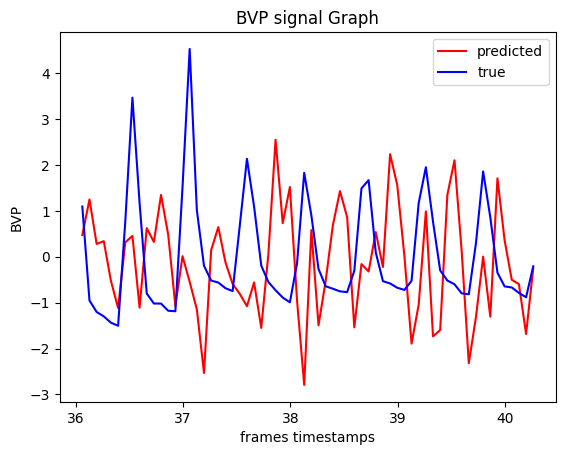

In [57]:
import matplotlib.pyplot as plt
print(test_folders)
print(" ")
for folder in test_folders:
    folder='subject45'
    new_video_path = '/kaggle/input/ubfcrppg-dataset-2/'+folder+'/vid.avi'
    gtfilename='/kaggle/input/ubfcrppg-dataset-2/'+folder+'/ground_truth.txt'

    # cap = cv2.VideoCapture(new_video_path)
    # frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # cap.release()

    gtdata = np.loadtxt(gtfilename)
    gtTrace = gtdata[0, :]
    gtTime = gtdata[2, :]

    ti=[]
    tr=[]
    gr=[]

    true_hr_l=[]
    pred_hr_l=[]

    for i in range(10):
        start=120*(i)
        frames, timestamps = frames_from_video_file(new_video_path, n_frames = FRAMES_NUM, start=start)
        input_sequence = np.array(frames)

        ti=timestamps

        input_sequence = np.expand_dims(input_sequence, axis=0)
        predictions = model.predict(input_sequence, verbose=0)
        pred_labels=predictions[0]
        tr=pred_labels


        gtTime, gtTrace = clean_data(gtTime, gtTrace)
        interp_func = CubicSpline(gtTime, gtTrace, bc_type='natural')
        true_labels=interp_func(timestamps)
        gr=true_labels

        true_hr=_calculate_fft_hr(true_labels, fs=30)
        true_hr_l.append(true_hr)

        pred_hr=_calculate_fft_hr(pred_labels, fs=15)
        pred_hr_l.append(pred_hr)

    print(f"{folder}: Avg. True HR = {np.mean(true_hr_l):.2f} Avg. Predicted HR = {np.mean(pred_hr_l):.2f}")
    random_noise = np.random.uniform(-0.5, 0.5, len(ti))
    plt.plot(ti, tr, label='predicted', color='red')
    plt.plot(ti, gr, label='true',color='blue')
    plt.title('BVP signal Graph')
    plt.legend()
    plt.xlabel('frames timestamps')
    plt.ylabel('BVP')
    plt.show()
    break

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# model= tf.keras.models.load_model('/kaggle/input/rppgmodels/your_trained_model.h5')
# ms=[]
# ma=[]
# for folder in test_folders:
#     print('Predicting for '+folder)
#     video_path = '/kaggle/input/ubfcrppg-dataset-2/'+folder+'/vid.avi'
#     gtfilename = '/kaggle/input/ubfcrppg-dataset-2/'+folder+'/ground_truth.txt'

#     cap = cv2.VideoCapture(video_path)
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# #     print(frame_count)
#     currFrame=0
#     predictions=[]
# #     true_hr=[]

#     gtdata = np.loadtxt(gtfilename)
#     gtTrace = gtdata[0, :]
#     gtTime = gtdata[2, :]
#     gtHR = gtdata[1, :]
    
# #     df = pd.read_csv(csv_file_path)
#     while(currFrame+FRAMES_NUM*2<frame_count):
#         frames, timestamps = frames_from_video_file(video_path, n_frames=FRAMES_NUM, start=currFrame)
#         input_sequence = np.array(frames)
#         input_sequence = np.expand_dims(input_sequence, axis=0)
#         prediction=model.predict(input_sequence, verbose=0)
#         predictions.extend(prediction[0])
# #         hr_values = df['NearestHeartRate'][currFrame:currFrame+FRAMES_NUM].values
# #         true_hr.append(np.mean(hr_values))
#         currFrame+=FRAMES_NUM*2
#     cap.release()
# #     print(gtTrace.shape)
# #     print(len(predictions))
# #     res = pd.DataFrame({'True_hr': true_hr, 'prediction': predictions})
# #     print(res)
#     gtTrace=gtTrace[0:len(predictions)]
#     rmse = np.sqrt(mean_squared_error(gtTrace, predictions))
#     mae = mean_absolute_error(gtTrace, predictions)
#     ms.append(rmse)
#     ma.append(mae)
#     print(f'RMSE: {rmse},  MAE: {mae}')
# #     break

# print(f'Avg. RMSE: {np.mean(ms)},  Avg. MAE: {np.mean(ma)}')